In [322]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import skfuzzy as fuzz

In [323]:
!pip install scikit-fuzzy

# Kmeans

## Carregando a base de dados e fazendo alguns pre-processamentos

In [324]:
df = pd.read_csv('/content/drive/MyDrive/Sitemas inteligentes/ObesityDataSet_raw_and_data_sinthetic.csv')
df.sample(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1888,Female,25.989938,1.644199,105.036075,yes,yes,3.000000,3.000000,Sometimes,no,2.310076,no,0.071150,0.733085,Sometimes,Public_Transportation,Obesity_Type_III
2077,Female,19.364339,1.808350,150.516480,yes,yes,3.000000,3.000000,Sometimes,no,2.305574,no,1.734424,0.863043,Sometimes,Public_Transportation,Obesity_Type_III
464,Male,18.000000,1.930000,86.000000,no,no,3.000000,4.000000,Always,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Normal_Weight
1927,Female,26.000000,1.650125,111.939671,yes,yes,3.000000,3.000000,Sometimes,no,2.770732,no,0.000000,0.125235,Sometimes,Public_Transportation,Obesity_Type_III
810,Female,21.071195,1.616467,68.771850,yes,yes,1.452524,3.950553,no,no,2.109858,no,0.508847,1.194633,Sometimes,Public_Transportation,Overweight_Level_I


In [325]:
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [326]:
df.shape

(2111, 17)

In [327]:
categoricas = ['Gender','family_history_with_overweight','FAVC','CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
encoder = OrdinalEncoder()
for cat in categoricas:
  df[cat] = encoder.fit_transform(df[[cat]])
df.sample(6)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
709,0.0,18.019572,1.701378,50.088468,0.0,1.0,1.601236,3.433908,2.0,0.0,1.055019,0.0,0.819269,1.030848,2.0,3.0,Insufficient_Weight
1129,1.0,21.123048,1.717037,80.000000,1.0,1.0,2.000000,3.000000,2.0,0.0,2.000000,0.0,2.270555,1.343044,3.0,3.0,Overweight_Level_II
652,0.0,21.287999,1.555778,42.360100,0.0,0.0,2.318355,1.082304,1.0,0.0,1.220365,0.0,0.033328,0.000000,3.0,3.0,Insufficient_Weight
1269,1.0,18.000000,1.792239,108.244379,1.0,1.0,2.000000,2.141839,2.0,0.0,2.939847,0.0,1.000000,0.103056,2.0,3.0,Obesity_Type_I
1447,1.0,22.719385,1.746645,96.875502,1.0,1.0,2.000000,3.000000,2.0,0.0,2.714091,0.0,2.641020,1.224737,3.0,3.0,Obesity_Type_I
2064,0.0,20.978166,1.721057,132.054793,1.0,1.0,3.000000,3.000000,2.0,0.0,1.678791,0.0,1.682490,0.818871,2.0,3.0,Obesity_Type_III


Separando as features do target

In [328]:
X = df.iloc[:, 0:16]
y = df.iloc[:, -1]

Dividindo a base de dados entre treino e teste

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

- Escalonando os dados para ficarem na mesma escala
- Atualização: sem o escalonamento dos dados, temos um resultado absurdamente maior do que com eles padronizados, por isso comentei essa parte

In [330]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

In [331]:
X_train.shape, X_test.shape

((1899, 16), (212, 16))

## Escolhendo o numero de clusters com base no metodo do cotovelo

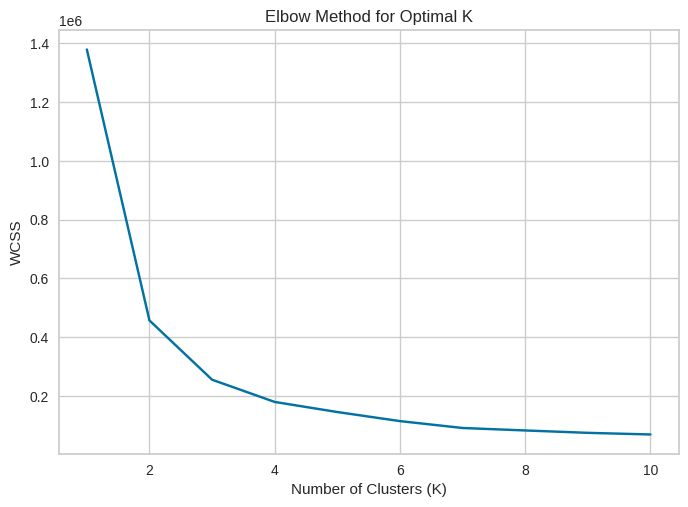

In [332]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


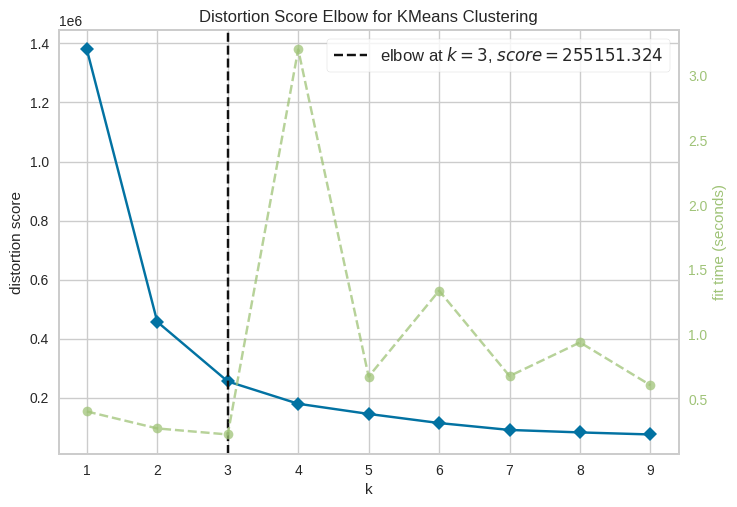

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [333]:
model = KMeans(n_init=10)  # Defina n_init explicitamente
visualizer = KElbowVisualizer(model, k=(1, 10), title="")

visualizer.fit(X_train)
visualizer.poof()

## Treinando o BASE MODEL

In [334]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)
cluster_labels = kmeans.predict(X_test)

kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([[6.08759124e-01, 2.62730502e+01, 1.70833346e+00, 8.38178691e+01,
        9.19708029e-01, 8.93430657e-01, 2.26503459e+00, 2.52817493e+00,
        1.88905109e+00, 1.89781022e-02, 1.99722389e+00, 2.48175182e-02,
        1.07984489e+00, 6.32806889e-01, 2.32554745e+00, 2.03503650e+00],
       [5.34072900e-01, 2.54512692e+01, 1.74256299e+00, 1.17185163e+02,
        9.96830428e-01, 9.85736926e-01, 2.64361968e+00, 2.85336777e+00,
        1.98415214e+00, 2.69413629e-02, 2.11192371e+00, 3.16957211e-03,
        8.41056445e-01, 5.95287588e-01, 2.10142631e+00, 2.48969889e+00],
       [3.56775300e-01, 2.09448207e+01, 1.64987139e+00, 5.67800074e+01,
        5.04288165e-01, 7.63293310e-01, 2.35959827e+00, 2.67649241e+00,
        1.69296741e+00, 2.05831904e-02, 1.91630247e+00, 1.16638079e-01,
        1.11884441e+00, 7.46976156e-01, 2.37735849e+00, 2.60205832e+00]])

In [335]:
pca = PCA(n_components=2) # Queremos reduzir a dimensionalidade para 2
df_2d = pca.fit_transform(X_test)
grafico = px.scatter(x = df_2d[:, 0], y = df_2d[:, 1], color = cluster_labels)
grafico.show()

In [336]:
silhouette_base_model = metrics.silhouette_score(X_test, cluster_labels)
print ('silhouette coefficient for the above clutering = ', silhouette_base_model)

silhouette coefficient for the above clutering =  0.5005730477798578


In [337]:
# Medindo a pureza
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_base = purity_score(y_test, cluster_labels)
print ('Purity for the above clutering = ', purity_base)

Purity for the above clutering =  0.42924528301886794


# Aplicando melhorias ao base model

## Verificando OUTLIERS nas colunas numericas usando BOXPLOT - 0.199

In [338]:
columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Criando boxplots interativos usando plotly
for col in columns:
    fig = px.box(df, y=col, title=f'Boxplot of {col}')
    fig.show()

Com base nesse grafico de boxplot, decidimos por tentar tirar NPC, uma vez que no seu grafico tem uma quantidade enorme de outliers, o que pode estar atrapalhando o andamento do modelo

In [339]:
X_train_NoNCP = X_train.drop(columns=['NCP'])
X_test_NoNCP = X_test.drop(columns=['NCP'])

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_NoNCP)

cluster_labels = kmeans.predict(X_test_NoNCP)
silhouette_avg = metrics.silhouette_score(X_test_NoNCP, cluster_labels)
print('Melhoria comparativamente da silhouette com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test, cluster_labels) - purity_base)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente da silhouette com o base model:  0.0015600443361838412
Melhoria comparativamente da purity com o base model: 0.0


Vamos tirar alguns outliers da coluna AGE e analisar a resposta do algoritmo

In [340]:
X_train_FilterAge = X_train[X_train['Age'] < 55]
X_test_FilterAge = X_test[X_test['Age'] < 55]

# Aplicando o mesmo filtro aos DataFrames Y_train e Y_test
y_train_FilterAge = y_train.loc[X_train_FilterAge.index]
y_test_FilterAge = y_test.loc[X_test_FilterAge.index]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_FilterAge)

cluster_labels = kmeans.predict(X_test_FilterAge)
silhouette_avg = metrics.silhouette_score(X_test_FilterAge, cluster_labels)
print ('Melhoria comparativamente com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test_FilterAge, cluster_labels) - purity_base)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente com o base model:  0.0
Melhoria comparativamente da purity com o base model: 0.0


Aplicando as mudanças calcular no DatataFrame Princial

In [341]:
X_train = X_train.drop(columns=['NCP'])
X_test = X_test.drop(columns=['NCP'])

X_train = X_train[X_train['Age'] < 55]
X_test = X_test[X_test['Age'] < 55]

# Aplicando o mesmo filtro aos DataFrames Y_train e Y_test
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

cluster_labels = kmeans.predict(X_test)
silhouette_base_model = metrics.silhouette_score(X_test, cluster_labels)
print ('silhouette coefficient for the above clutering = ', silhouette_base_model)
purity_base = purity_score(y_test, cluster_labels)
print ('Purity for the above clutering = ', purity_base)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette coefficient for the above clutering =  0.5021330921160416
Purity for the above clutering =  0.42924528301886794


## Vendo correlações entre as features  

In [342]:
X_train.sample(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
1066,1.0,31.398281,1.919543,101.544589,1.0,1.0,2.000000,2.0,0.0,2.001936,0.0,1.000000,0.000000,2.0,3.0
160,1.0,20.000000,1.830000,72.000000,1.0,0.0,3.000000,2.0,1.0,1.000000,0.0,2.000000,1.000000,2.0,3.0
1208,0.0,45.821267,1.687326,80.413997,1.0,1.0,2.076689,2.0,0.0,1.026729,0.0,0.647798,0.000000,3.0,0.0
1430,1.0,37.936044,1.785957,99.199287,1.0,1.0,2.045160,2.0,0.0,2.856521,0.0,2.005286,0.105408,2.0,0.0
1917,0.0,21.768153,1.764160,133.888629,1.0,1.0,3.000000,2.0,0.0,2.325020,0.0,1.441791,0.918468,2.0,3.0


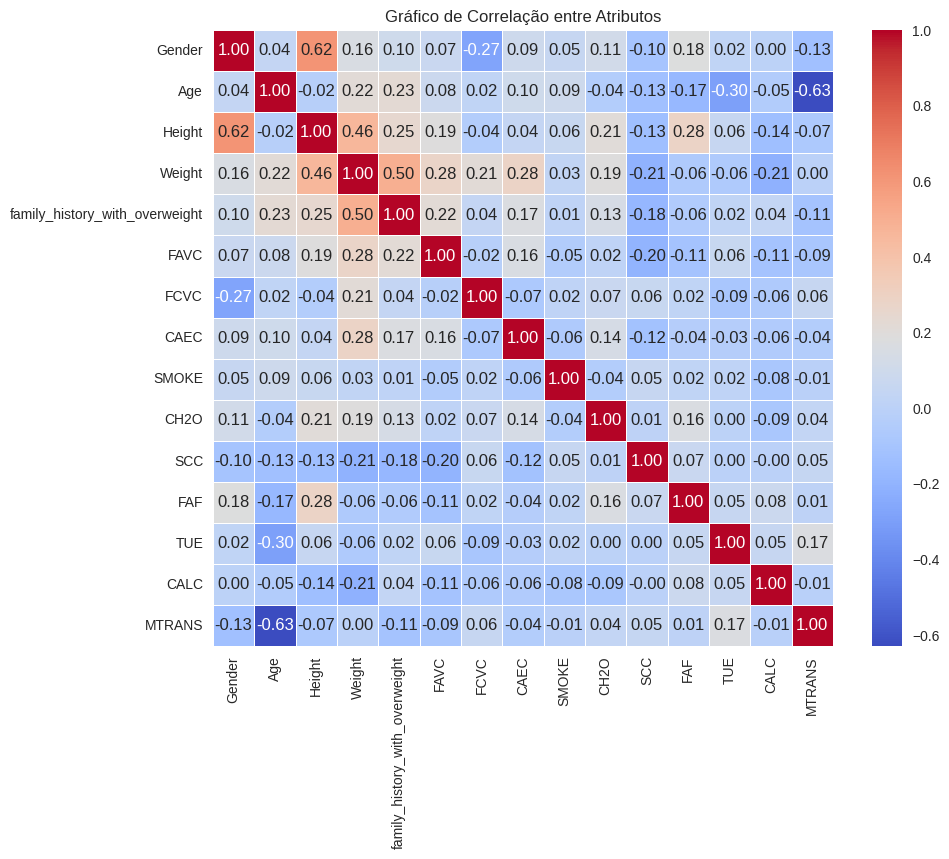

In [343]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Gráfico de Correlação entre Atributos")
plt.show()

Ao analisar essa matrix, percebemos que temos 2 fortes correlações na base de dados, vamos tentar melhorar o modelo a parte da analise de ambas

### Corr 1: Gender X Height

Teste 1: Excluindo Genero e medindo a silhouette_score

In [344]:
# Vamos excluir o genero, escalonar os dados e testar o coeficiente de silhouette
X_train_NoGender = X_train.drop(columns=['Gender'])
X_test_NoGender = X_test.drop(columns=['Gender'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_NoGender)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_NoGender)

cluster_labels = kmeans.predict(X_test_NoGender)
silhouette_avg = metrics.silhouette_score(X_test_NoGender, cluster_labels)
print ('Melhoria comparativamente com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test, cluster_labels) - purity_base)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente com o base model:  0.0006531059209590184
Melhoria comparativamente da purity com o base model: 0.0


Houve uma pequena melhoria

Teste 2: Excluindo Height e medindo a silhouette

In [345]:
# Vamos excluir a altura, escalonar os dados e testar o coeficiente de silhouette
X_train_NoHeight = X_train.drop(columns=['Height'])
X_test_NoHeight = X_test.drop(columns=['Height'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_NoHeight)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_NoHeight)

cluster_labels = kmeans.predict(X_test_NoHeight)
silhouette_avg = metrics.silhouette_score(X_test_NoHeight, cluster_labels)
print ('Melhoria comparativamente com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test, cluster_labels) - purity_base)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente com o base model:  2.14439525101362e-05
Melhoria comparativamente da purity com o base model: 0.0


Com isso chegamos a conclusão que apesar dos dois apresentarem uma melhora na metrica escolhida, alteraria a interpretabilidade e sentido da base de dados, portanto, o grupo decidiu por nao tirar nenhum desses


### Corr 2: Age X MTRANS

In [346]:
# Vamos excluir o atributo MTRANS, escalonar os dados e testar o coeficiente de silhouette
X_train_NoMtrans = X_train.drop(columns=['MTRANS'])
X_test_NoMtrans = X_test.drop(columns=['MTRANS'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_NoMtrans)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_NoMtrans)

cluster_labels = kmeans.predict(X_test_NoMtrans)
silhouette_avg = metrics.silhouette_score(X_test_NoMtrans, cluster_labels)
print ('Melhoria comparativamente com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test, cluster_labels) - purity_base)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente com o base model:  0.003174286069079102
Melhoria comparativamente da purity com o base model: 0.0


In [347]:
# Vamos excluir o atributo Age, escalonar os dados e testar o coeficiente de silhouette
X_train_NoAge = X_train.drop(columns=['Age'])
X_test_NoAge = X_test.drop(columns=['Age'])
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_NoAge)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_NoAge)

cluster_labels = kmeans.predict(X_test_NoAge)
silhouette_avg = metrics.silhouette_score(X_test_NoAge, cluster_labels)
print ('Melhoria comparativamente com o base model: ', silhouette_avg - silhouette_base_model)
print('Melhoria comparativamente da purity com o base model:', purity_score(y_test, cluster_labels) - purity_base)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Melhoria comparativamente com o base model:  0.06632092614892249
Melhoria comparativamente da purity com o base model: 0.004716981132075471


Tirando a idade, acontece uma melhora maior, porem, pela parte interpretativa, escolhemos por tirar o atributo MTRANS ao inves da idade

Subindo as alterações pra base de dados principal

In [348]:
X_train = X_train.drop(columns=['Age'])
X_test = X_test.drop(columns=['Age'])

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

cluster_labels = kmeans.predict(X_test)
silhouette_base_model = metrics.silhouette_score(X_test, cluster_labels)
print ('silhouette coefficient for the above clutering = ', silhouette_base_model)
print ('Purity for the above clutering = ', purity_score(y_test, cluster_labels))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette coefficient for the above clutering =  0.5684540182649641
Purity for the above clutering =  0.4339622641509434


## Mudando os parametros

O codigo base otimizar os parametros usará GridSearchCV

In [349]:
def optimize(n_clusters, init, n_init, max_iter, tol, algorithm, params, cv = 5):
  np.random.seed(0)
  Kms = KMeans(n_clusters=n_clusters,init=init,n_init=n_init,max_iter=max_iter,tol=tol,algorithm=algorithm,random_state = 0)
  # Usaremos GridSearchCV: Tecnica que usa validação cruzada para fazer a combinação e teste com varios parametros e vai retornar o melhor deles
  grid_search = GridSearchCV(estimator = Kms, param_grid = params,n_jobs = -1, cv = cv) # Param_grid é a lista de parametros que ele irá testar
  grid_search.fit(X) # GridSearch ja faz a diferenciação de treino e test por si so

  melhores_parametros = grid_search.best_params_
  best_kmeans_model = grid_search.best_estimator_

  melhor_resultado = metrics.silhouette_score(X, best_kmeans_model.labels_) # pegando o silhouette_score para o melhor modelo a partir da validação cruzada
  print(f'melhores parametros pelo GridSearch: {melhores_parametros}')
  print('silhouette coefficient for the above clutering = ', melhor_resultado)


  return melhores_parametros, melhor_resultado

Lista de Parametros default

In [350]:
n_clusters = 3 # Regra do cotovelo
init =  'k-means++'
n_init = 10
max_iter = 300
tol = 1e-4
algorithm = 'auto'
opt_paramns = dict() # São os melhores parametros que vamos calcular a partir da otimização

Para questões comparativas, o Base model inicial estava com uma sihouette de **0.50057**

### Otimizando **init**

In [351]:
init =  None
params = {'init': ['k-means++', 'random']} # Possiveis valores pra init
opt_param, score = optimize(n_clusters=n_clusters,
                            init=init,
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=tol,
                            algorithm=algorithm,
                            params=params)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning:

algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



melhores parametros pelo GridSearch: {'init': 'k-means++'}
silhouette coefficient for the above clutering =  0.5005126385469671


In [352]:
init = 'k-means++' # deixaremos o default

### Otimizando o **n_init**

In [353]:
n_init = None
params = {'n_init': range(10, 101, 10)} # Possiveis valores pra n_init
opt_param, score = optimize(n_clusters=n_clusters,
                            init=init,
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=tol,
                            algorithm=algorithm,
                            params=params)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning:

algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



melhores parametros pelo GridSearch: {'n_init': 10}
silhouette coefficient for the above clutering =  0.5005126385469671


In [354]:
n_init = 10 # deixaremos o default

### Otimizando **max_iter**

In [355]:
max_iter = None
params = {'max_iter': [200, 300, 500, 1000]} # Possiveis valores pra n_init
opt_param, score = optimize(n_clusters=n_clusters,
                            init=init,
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=tol,
                            algorithm=algorithm,
                            params=params)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning:

algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



melhores parametros pelo GridSearch: {'max_iter': 200}
silhouette coefficient for the above clutering =  0.5005126385469671


In [356]:
max_iter = 300 # deixaremos o default

### Otimizando **tol**

In [357]:
tol = None  # Para manter a consistência com o seu código anterior
params = {'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

opt_param, score = optimize(n_clusters=n_clusters,
                            init=init,
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=tol,
                            algorithm=algorithm,
                            params=params)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning:

algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



melhores parametros pelo GridSearch: {'tol': 0.0001}
silhouette coefficient for the above clutering =  0.5005126385469671


In [358]:
tol = 1e-4# deixaremos o default

### Otimizando **algorithm**

In [359]:
algorithm = None  # Para manter a consistência com o seu código anterior
params = {'algorithm': ['full', 'elkan', 'auto']}

opt_param, score = optimize(n_clusters=n_clusters,
                            init=init,
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=tol,
                            algorithm=algorithm,
                            params=params)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



melhores parametros pelo GridSearch: {'algorithm': 'full'}
silhouette coefficient for the above clutering =  0.5005126385469671


In [360]:
algorithm = 'auto'# deixaremos o default

Com isso, chegamos a conclusão que, para esse base de dados, os melhores parametros sao os dafault

# DBSCAN

In [361]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
# Em DBSCAN, nao temos o .predict(), logo, nao precisarwemos fazer a diferenciação entre X_train e X_test, entao vamos concatena-los
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

cluster_labels_dbscan = dbscan.fit_predict(X_scaled)

# Calcule o silhouette score
silhouette_avg_dbscan = metrics.silhouette_score(X_scaled, cluster_labels_dbscan)

print('Silhouette coefficient for DBSCAN clustering =', silhouette_avg_dbscan)
purity_base = purity_score(y_combined, cluster_labels_dbscan)
print ('Purity for the above clutering = ', purity_base)

Silhouette coefficient for DBSCAN clustering = -0.2015722097448407
Purity for the above clutering =  0.404467680608365


Contextualização: Apesar de em Kmeans não usarmos a padronização dos dados, em DBSCAN o algoritmo se saiu melhor

## Otimizando os parametros do DBSCAN

In [362]:
# Colocando os parametros que queremos testar
eps_values = np.arange(0.1, 0.9, 0.1)
min_samples_values = range(1, 10)

# Inicializando os melhores parametros que serão retornaros como None
best_eps = None
best_min_samples = None
best_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Apenas calculando o Coeficiente de Silhueta para clusterizações com mais de 1 cluster e menos que o número total de pontos
        if len(set(labels)) > 1 and -1 in labels:
            score = metrics.silhouette_score(X_scaled, labels) # silhouette
            purity_base = purity_score(y_combined, labels)
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score
                best_purity = purity_base

print(f"Melhor eps: {best_eps}")
print(f"Melhor min_samples: {best_min_samples}")
print(f"Melhor Coeficiente de Silhueta: {best_score}")
print(f'Melhor purity: {best_purity}')

Melhor eps: 0.8
Melhor min_samples: 2
Melhor Coeficiente de Silhueta: -0.056276635021174436
Melhor purity: 0.7105513307984791


Plotando grafico para melhor interpretação

In [363]:
model = DBSCAN(eps=0.8, min_samples=2)
cluster_labels = model.fit_predict(X_scaled)
pca = PCA(n_components=2) # Queremos reduzir a dimensionalidade para 2
df_2d = pca.fit_transform(X_scaled)
grafico = px.scatter(x = df_2d[:, 0], y = df_2d[:, 1], color = cluster_labels)
grafico.show()

# fuzzy cMeans

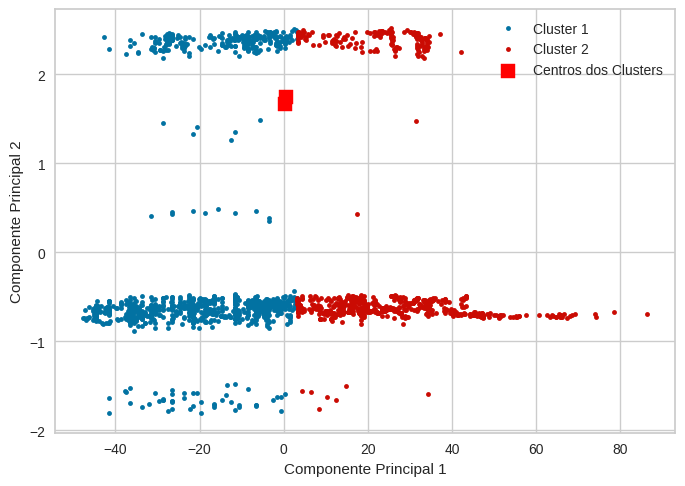

Valor FPC: 0.85


In [364]:
ncenters = 2

# parametros que serão futuramente otimizado
error = 0.005
max_iter = 1000
init = None

# aplicando o cMeans
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_combined.T, ncenters, 2, error=error, maxiter=max_iter, init=init)

# Visuzaliando os clusters resultantes
cluster_membership = np.argmax(u, axis=0)

# Reduzindo a dimensionalidade para plotar o grafico
pca = PCA(n_components=2)
df_2d = pca.fit_transform(X_combined)


# Plotando os dados
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
for j in range(ncenters):
    plt.plot(df_2d[cluster_membership == j, 0],
             df_2d[cluster_membership == j, 1], '.', color=colors[j], label=f'Cluster {j + 1}')

plt.scatter(cntr[:, 0], cntr[:, 1], marker='s', s=100, c='red', label='Centros dos Clusters')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()

plt.show()

print(f'Valor FPC: {fpc:.2f}')

In [365]:
# Verificando os resultados
silhouette_avg = metrics.silhouette_score(X_combined, cluster_membership)
print(f'Coeficiente de Silhueta: {silhouette_avg}')
purity_base = purity_score(y_combined, cluster_labels_dbscan)
print ('Purity for the above clutering = ', purity_base)

Coeficiente de Silhueta: 0.6046457246230491
Purity for the above clutering =  0.404467680608365


## Otimizando os parametros de Fuzzy C-Means

In [366]:
# parametros que serão futuramente otimizado
ncenters_values = range(2, 11)
error_values = [0.001, 0.005, 0.01]
max_iter_values = [100, 500, 1000]

best_ncenters = None
best_error = None
best_max_iter = None
best_score = -1

# Aplicando a redução de dimensionalidade usando PCA
pca = PCA(n_components=2)
df_2d = pca.fit_transform(X_scaled)

for ncenters in ncenters_values:
    for error in error_values:
        for max_iter in max_iter_values:
            # Aplicandoo o algoritmo c-Means
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                X_combined.T, ncenters, 2, error=error, maxiter=max_iter, init=None)

            # Calculando a associação de cluster para cada ponto de dados
            cluster_membership = np.argmax(u, axis=0)

            # Calcula o Coeficiente de Silhueta
            silhouette_avg = metrics.silhouette_score(X_combined, cluster_membership)
            purity_base = purity_score(y_combined, labels)
            if silhouette_avg > best_score:
                best_ncenters = ncenters
                best_error = error
                best_max_iter = max_iter
                best_score = silhouette_avg
                best_purity = purity_base

print(f"Melhor número de centros de clusters: {best_ncenters}")
print(f"Melhor valor de erro: {best_error}")
print(f"Melhor número máximo de iterações: {best_max_iter}")
print(f"Melhor Coeficiente de Silhueta: {best_score}")
print(f'Melhor purity: {best_purity}')

Melhor número de centros de clusters: 2
Melhor valor de erro: 0.001
Melhor número máximo de iterações: 100
Melhor Coeficiente de Silhueta: 0.6046457246230491
Melhor purity: 0.43155893536121676
